# 8 Pilares Estadisticos: Evaluacion de Tasas de Interes

**Traduciendo conceptos academicos para Data Science al mundo real**

Este notebook evalua los datos de Tasas de Interes procesados por `ETL_Principales.py`:

1. **Distribuciones** - Forma de los datos
2. **Centro de Gravedad** - Media, Mediana, Moda
3. **Fiabilidad** - Riesgo y volatilidad
4. **Margen de Error** - Intervalos de confianza
5. **Pruebas de Hipotesis** - Chi-cuadrada
6. **Regresion/Prediccion** - Machine Learning
7. **Series de Tiempo** - Tendencias y estacionalidad
8. **ANOVA** - Comparacion entre grupos

**Variables:**
- TasaMXN: Tasa de referencia de Banxico
- TasaUSD: Federal Funds Rate (Fed)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
from scipy.stats import chi2_contingency, shapiro, normaltest, kruskal
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

BASE_DIR = Path('..').resolve()
DATOS_RESULTADO = BASE_DIR / 'Datos_Resultado'
print(f"Directorio: {BASE_DIR}")

Directorio: C:\Users\ARTUROJF\Desktop\Final


## Carga de Datos

In [2]:
path_datos = DATOS_RESULTADO / 'TasaInteres_Trimestral.csv'
df = pd.read_csv(path_datos) if path_datos.exists() else pd.DataFrame()

print(f"Datos: {len(df)} filas x {len(df.columns)} columnas")
print(f"Columnas: {df.columns.tolist()}")
df.head(10)

Datos: 286 filas x 3 columnas
Columnas: ['periodo', 'TasaMXN', 'TasaUSD']


,periodo,TasaMXN,TasaUSD
0,1954-07-01,NaN,1.0300
1,1954-10-01,NaN,0.9867
2,1955-01-01,NaN,1.3433
3,1955-04-01,NaN,1.5000
4,1955-07-01,NaN,1.9400
5,1955-10-01,NaN,2.3567
6,1956-01-01,NaN,2.4833
7,1956-04-01,NaN,2.6933
8,1956-07-01,NaN,2.8100
9,1956-10-01,NaN,2.9267


In [3]:
df['periodo'] = pd.to_datetime(df['periodo'])
df = df.sort_values('periodo').reset_index(drop=True)
df['TRIMESTRE'] = df['periodo'].dt.quarter
df['year'] = df['periodo'].dt.year

cols_numericas = ['TasaMXN', 'TasaUSD']
cols_numericas = [c for c in cols_numericas if c in df.columns]

# Calcular spread
if 'TasaMXN' in df.columns and 'TasaUSD' in df.columns:
    df['Spread'] = df['TasaMXN'] - df['TasaUSD']
    cols_numericas.append('Spread')

VAR_PRINCIPAL = 'TasaUSD' if 'TasaUSD' in df.columns else cols_numericas[0]
print(f"Variable principal: {VAR_PRINCIPAL}")
print(f"Periodo: {df['periodo'].min()} a {df['periodo'].max()}")
df[cols_numericas].describe()

Variable principal: TasaUSD
Periodo: 1954-07-01 00:00:00 a 2025-10-01 00:00:00


,TasaMXN,TasaUSD,Spread
count,72.000000,285.000000,71.00000
mean,6.196301,4.606281,4.83907
std,2.484058,3.531329,1.13822
min,3.000000,0.060000,2.86330
25%,4.379075,1.940000,4.19170
50%,5.382800,4.330000,4.42670
75%,7.857350,6.220000,5.83615
max,11.250000,17.780000,7.74330


---
## PILAR 1: Distribuciones

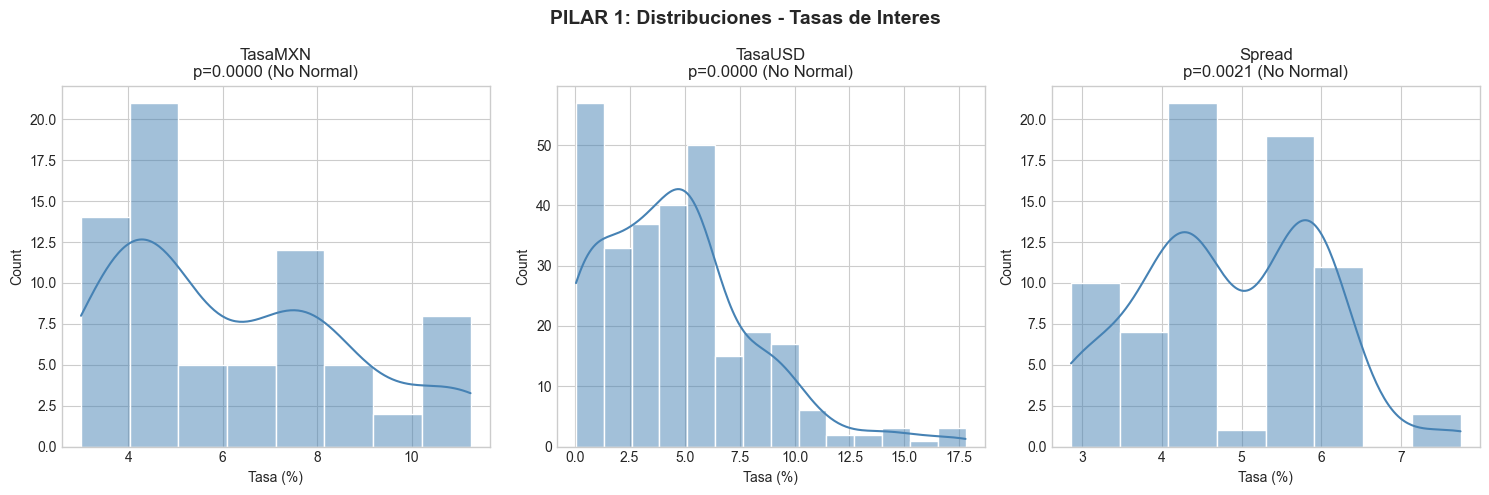


RESUMEN DE NORMALIDAD:
TasaMXN         | p=0.0000 | No Normal
TasaUSD         | p=0.0000 | No Normal
Spread          | p=0.0021 | No Normal


In [4]:
n_vars = len(cols_numericas)
fig, axes = plt.subplots(1, min(3, n_vars), figsize=(15, 5))
if n_vars == 1:
    axes = [axes]
fig.suptitle('PILAR 1: Distribuciones - Tasas de Interes', fontsize=14, fontweight='bold')

for idx, var in enumerate(cols_numericas[:3]):
    ax = axes[idx] if n_vars > 1 else axes[0]
    data = df[var].dropna()
    sns.histplot(data, kde=True, ax=ax, color='steelblue', edgecolor='white')
    
    if len(data) >= 20:
        _, p = shapiro(data) if len(data) < 5000 else normaltest(data)
        ax.set_title(f'{var}\np={p:.4f} ({"Normal" if p > 0.05 else "No Normal"})')
    ax.set_xlabel('Tasa (%)')

plt.tight_layout()
plt.show()

print("\nRESUMEN DE NORMALIDAD:")
for var in cols_numericas:
    data = df[var].dropna()
    if len(data) >= 20:
        _, p = shapiro(data) if len(data) < 5000 else normaltest(data)
        print(f"{var:15} | p={p:.4f} | {'Normal' if p > 0.05 else 'No Normal'}")

---
## PILAR 2: Centro de Gravedad

In [5]:
print("PILAR 2: MEDIDAS DE TENDENCIA CENTRAL")
print("="*60)

stats_centro = []
for var in cols_numericas:
    data = df[var].dropna()
    stats_centro.append({
        'Variable': var,
        'Media': data.mean(),
        'Mediana': data.median(),
        'Desv. Std': data.std(),
        'Min': data.min(),
        'Max': data.max()
    })

pd.DataFrame(stats_centro)

PILAR 2: MEDIDAS DE TENDENCIA CENTRAL


,Variable,Media,Mediana,Desv. Std,Min,Max
0,TasaMXN,6.196301,5.3828,2.484058,3.0000,11.2500
1,TasaUSD,4.606281,4.3300,3.531329,0.0600,17.7800
2,Spread,4.839070,4.4267,1.138220,2.8633,7.7433


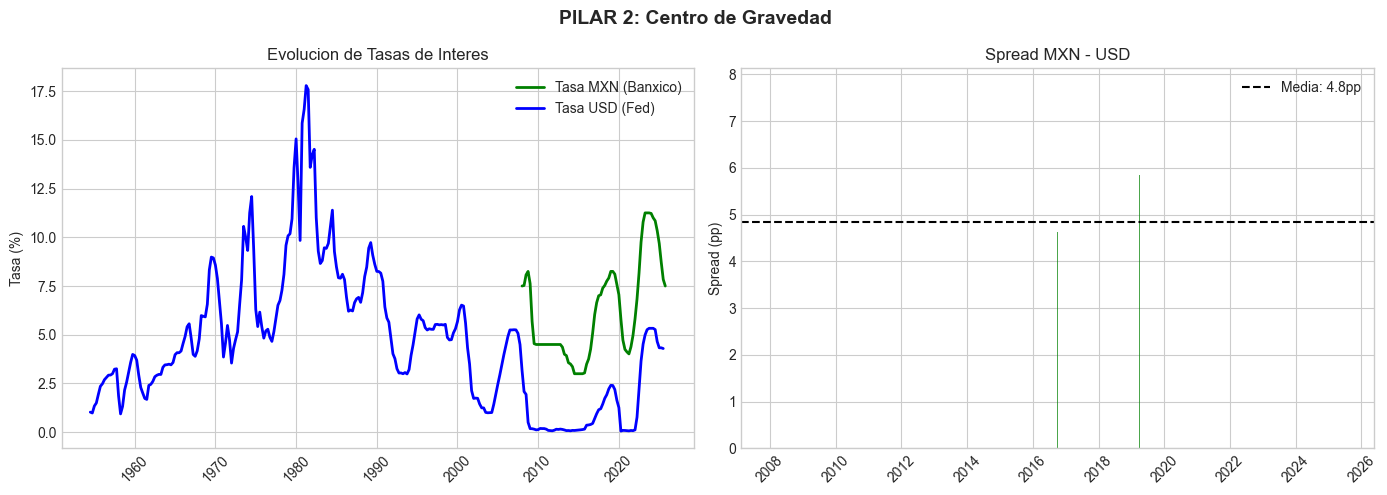

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('PILAR 2: Centro de Gravedad', fontsize=14, fontweight='bold')

# Evolucion tasas
if 'TasaMXN' in df.columns:
    axes[0].plot(df['periodo'], df['TasaMXN'], label='Tasa MXN (Banxico)', linewidth=2, color='green')
if 'TasaUSD' in df.columns:
    axes[0].plot(df['periodo'], df['TasaUSD'], label='Tasa USD (Fed)', linewidth=2, color='blue')
axes[0].set_ylabel('Tasa (%)')
axes[0].set_title('Evolucion de Tasas de Interes')
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45)

# Spread
if 'Spread' in df.columns:
    spread = df['Spread'].dropna()
    colors = ['green' if s > 0 else 'red' for s in spread]
    axes[1].bar(df.loc[spread.index, 'periodo'], spread, color=colors, alpha=0.7)
    axes[1].axhline(spread.mean(), color='black', linestyle='--', label=f'Media: {spread.mean():.1f}pp')
    axes[1].set_ylabel('Spread (pp)')
    axes[1].set_title('Spread MXN - USD')
    axes[1].legend()
    axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

---
## PILAR 3: Fiabilidad

In [7]:
print("PILAR 3: FIABILIDAD Y VOLATILIDAD")
print("="*60)

stats_fiab = []
for var in cols_numericas:
    data = df[var].dropna()
    if len(data) > 0 and data.mean() != 0:
        cv = data.std() / abs(data.mean()) * 100
        cambio = data.diff().dropna()
        stats_fiab.append({
            'Variable': var,
            'CV (%)': cv,
            'Cambio Prom (pp)': cambio.mean(),
            'Volatilidad (pp)': cambio.std()
        })

pd.DataFrame(stats_fiab)

PILAR 3: FIABILIDAD Y VOLATILIDAD


,Variable,CV (%),Cambio Prom (pp),Volatilidad (pp)
0,TasaMXN,40.089371,6.254778e-18,0.574673
1,TasaUSD,76.663338,1.149049e-02,0.840613
2,Spread,23.521455,-1.109857e-02,0.485377


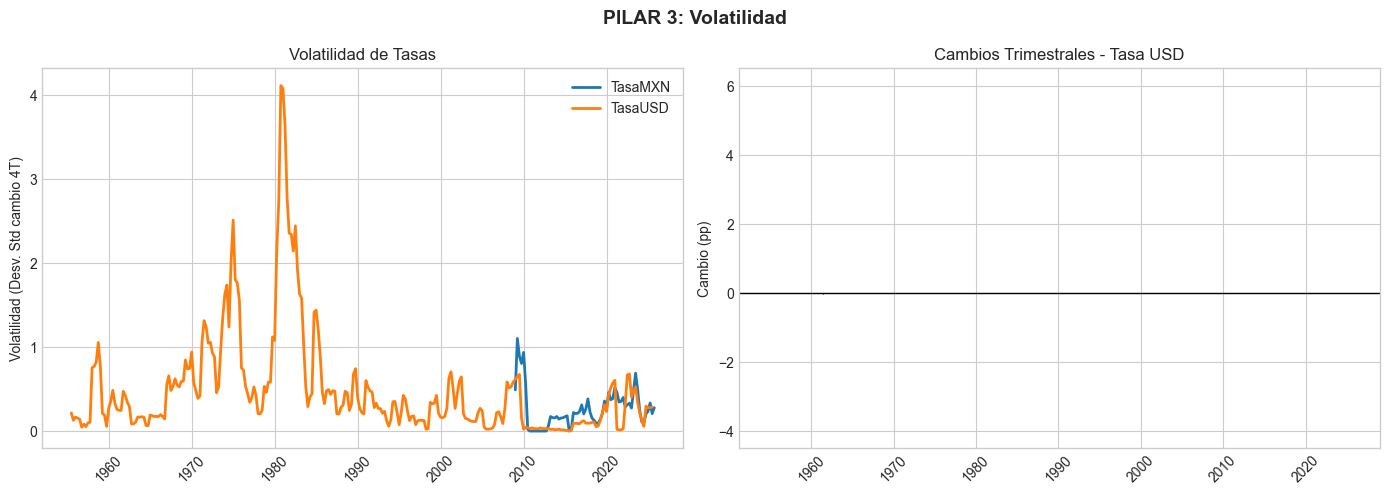

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('PILAR 3: Volatilidad', fontsize=14, fontweight='bold')

# Rolling volatilidad
for var in ['TasaMXN', 'TasaUSD']:
    if var in df.columns:
        vol = df[var].diff().rolling(4).std()
        axes[0].plot(df['periodo'], vol, label=var, linewidth=2)
axes[0].set_ylabel('Volatilidad (Desv. Std cambio 4T)')
axes[0].set_title('Volatilidad de Tasas')
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45)

# Cambios en tasas
if 'TasaUSD' in df.columns:
    cambio = df['TasaUSD'].diff()
    colors = ['red' if c > 0 else 'green' if c < 0 else 'gray' for c in cambio]
    axes[1].bar(df['periodo'], cambio, color=colors, alpha=0.7)
    axes[1].axhline(0, color='black', linewidth=1)
    axes[1].set_ylabel('Cambio (pp)')
    axes[1].set_title('Cambios Trimestrales - Tasa USD')
    axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

---
## PILAR 4: Margen de Error

In [9]:
print("PILAR 4: INTERVALOS DE CONFIANZA (95%)")
print("="*60)

def ic(data, conf=0.95):
    n = len(data)
    m = data.mean()
    se = stats.sem(data)
    h = se * stats.t.ppf((1 + conf) / 2, n - 1)
    return m - h, m + h, h

for var in cols_numericas:
    data = df[var].dropna()
    if len(data) >= 10:
        low, high, margin = ic(data)
        print(f"{var:15}: {data.mean():.2f}% [{low:.2f}, {high:.2f}] +/-{margin:.2f}")

PILAR 4: INTERVALOS DE CONFIANZA (95%)
TasaMXN        : 6.20% [5.61, 6.78] +/-0.58
TasaUSD        : 4.61% [4.19, 5.02] +/-0.41
Spread         : 4.84% [4.57, 5.11] +/-0.27


---
## PILAR 5: Pruebas de Hipotesis

In [10]:
print("PILAR 5: PRUEBAS DE HIPOTESIS")
print("="*60)

df_test = df.copy()

# Categorizar nivel de tasas
if 'TasaUSD' in df_test.columns:
    df_test['tasa_cat'] = pd.cut(df_test['TasaUSD'], 
                                  bins=[-np.inf, 1, 3, 5, np.inf], 
                                  labels=['Muy Baja (<1%)', 'Baja (1-3%)', 'Media (3-5%)', 'Alta (>5%)'])
    
    print("\n--- H1: Nivel Tasa vs Trimestre ---")
    contingencia = pd.crosstab(df_test['tasa_cat'].dropna(), df_test.loc[df_test['tasa_cat'].notna(), 'TRIMESTRE'])
    print(contingencia)
    
    if contingencia.shape[0] > 1 and contingencia.shape[1] > 1:
        chi2, p_value, _, _ = chi2_contingency(contingencia)
        print(f"\nChi2={chi2:.4f}, p={p_value:.4f}")
    else:
        p_value = 1.0
else:
    p_value = 1.0

PILAR 5: PRUEBAS DE HIPOTESIS

--- H1: Nivel Tasa vs Trimestre ---
TRIMESTRE        1   2   3   4
tasa_cat                      
Muy Baja (<1%)  11  13  10  13
Baja (1-3%)     15  14  15  13
Media (3-5%)    18  15  13  15
Alta (>5%)      27  29  34  30

Chi2=2.4522, p=0.9821


In [11]:
# H2: Ciclos de politica monetaria (subida vs bajada)
print("\n--- H2: Direccion de politica monetaria ---")
if 'TasaUSD' in df_test.columns:
    df_test['direccion'] = df_test['TasaUSD'].diff().apply(
        lambda x: 'Subida' if x > 0 else 'Bajada' if x < 0 else 'Sin cambio')
    
    df_test['decada'] = (df_test['year'] // 10) * 10
    contingencia2 = pd.crosstab(df_test['direccion'].dropna(), df_test.loc[df_test['direccion'].notna(), 'decada'])
    print(contingencia2)
    
    if contingencia2.shape[0] > 1 and contingencia2.shape[1] > 1:
        chi2_2, p_value_2, _, _ = chi2_contingency(contingencia2)
        print(f"\nChi2={chi2_2:.4f}, p={p_value_2:.6f}")
    else:
        p_value_2 = 1.0
else:
    p_value_2 = 1.0


--- H2: Direccion de politica monetaria ---
decada      1950  1960  1970  1980  1990  2000  2010  2020
direccion                                                 
Bajada         3    16    16    19    24    23    14    10
Sin cambio     1     0     0     0     0     1     1     4
Subida        18    24    24    21    16    16    25    10

Chi2=41.7990, p=0.000133


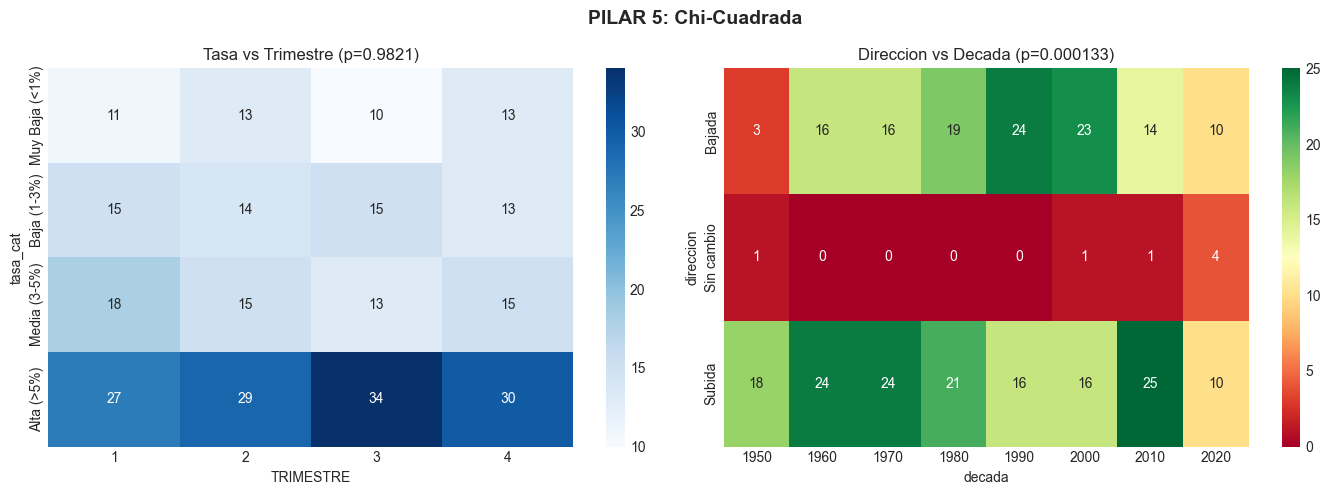

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('PILAR 5: Chi-Cuadrada', fontsize=14, fontweight='bold')

if 'tasa_cat' in df_test.columns:
    sns.heatmap(contingencia, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title(f'Tasa vs Trimestre (p={p_value:.4f})')

if 'direccion' in df_test.columns:
    sns.heatmap(contingencia2, annot=True, fmt='d', cmap='RdYlGn', ax=axes[1])
    axes[1].set_title(f'Direccion vs Decada (p={p_value_2:.6f})')

plt.tight_layout()
plt.show()

---
## PILAR 6: Prediccion ML

In [13]:
print("PILAR 6: MACHINE LEARNING")
print("="*60)

df_ml = df.copy()

# Crear lags
target_var = 'TasaUSD' if 'TasaUSD' in df_ml.columns else cols_numericas[0]
df_ml['tasa_lag1'] = df_ml[target_var].shift(1)
df_ml['tasa_lag2'] = df_ml[target_var].shift(2)
df_ml['tasa_lag4'] = df_ml[target_var].shift(4)

features = ['tasa_lag1', 'tasa_lag2', 'tasa_lag4', 'TRIMESTRE', 'year']
features = [f for f in features if f in df_ml.columns]
target = target_var

df_ml = df_ml[features + [target]].dropna()
X = df_ml[features]
y = df_ml[target]

print(f"Features: {features}")
print(f"Observaciones: {len(df_ml)}")

if len(df_ml) >= 20:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

PILAR 6: MACHINE LEARNING
Features: ['tasa_lag1', 'tasa_lag2', 'tasa_lag4', 'TRIMESTRE', 'year']
Observaciones: 281


In [14]:
if len(df_ml) >= 20:
    modelos = {
        'Regresion Lineal': LinearRegression(),
        'Ridge': Ridge(alpha=1.0),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
    }
    
    resultados = []
    predicciones = {}
    
    for nombre, modelo in modelos.items():
        if 'Forest' in nombre or 'Boosting' in nombre:
            modelo.fit(X_train, y_train)
            y_pred = modelo.predict(X_test)
        else:
            modelo.fit(X_train_scaled, y_train)
            y_pred = modelo.predict(X_test_scaled)
        
        resultados.append({
            'Modelo': nombre,
            'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
            'MAE': mean_absolute_error(y_test, y_pred),
            'R2': r2_score(y_test, y_pred)
        })
        predicciones[nombre] = y_pred
    
    df_resultados = pd.DataFrame(resultados).sort_values('R2', ascending=False)
    print(df_resultados.to_string(index=False))
    mejor_modelo = df_resultados.iloc[0]['Modelo']
    print(f"\n*** MEJOR: {mejor_modelo} (R2={df_resultados.iloc[0]['R2']:.4f}) ***")
else:
    print("Datos insuficientes")
    mejor_modelo = 'N/A'
    df_resultados = pd.DataFrame()

           Modelo     RMSE      MAE       R2
    Random Forest 1.103536 0.582377 0.891605
            Ridge 1.147953 0.503069 0.882704
 Regresion Lineal 1.197479 0.515180 0.872365
Gradient Boosting 1.228383 0.633940 0.865692

*** MEJOR: Random Forest (R2=0.8916) ***


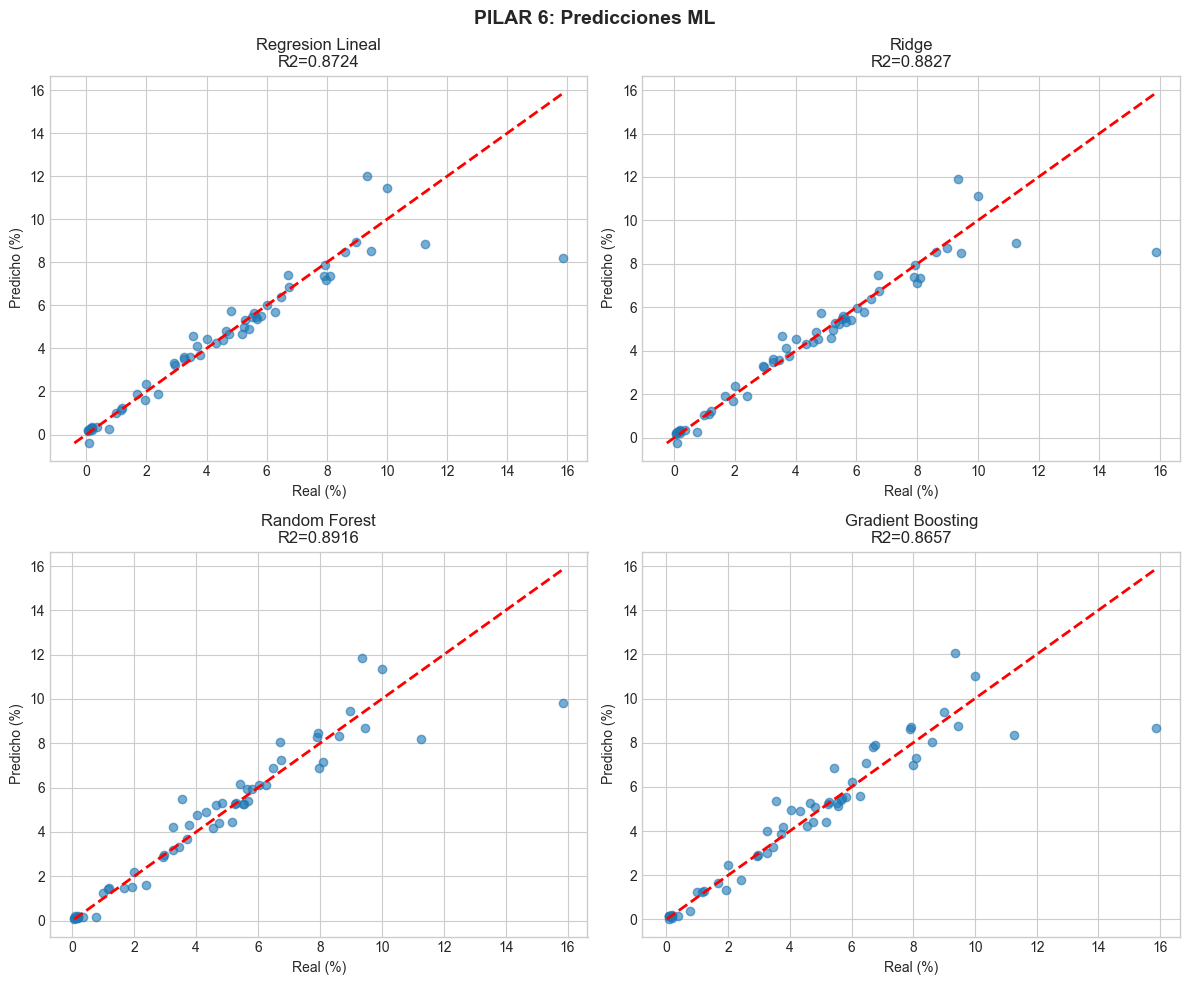

In [15]:
if len(df_ml) >= 20 and len(predicciones) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle('PILAR 6: Predicciones ML', fontsize=14, fontweight='bold')
    
    for idx, (nombre, y_pred) in enumerate(predicciones.items()):
        ax = axes[idx // 2, idx % 2]
        ax.scatter(y_test, y_pred, alpha=0.6)
        lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
        ax.plot(lims, lims, 'r--', linewidth=2)
        ax.set_xlabel('Real (%)')
        ax.set_ylabel('Predicho (%)')
        ax.set_title(f'{nombre}\nR2={r2_score(y_test, y_pred):.4f}')
    
    plt.tight_layout()
    plt.show()

---
## PILAR 7: Series de Tiempo

In [16]:
print("PILAR 7: SERIES DE TIEMPO")
print("="*60)

ts_var = 'TasaUSD' if 'TasaUSD' in df.columns else cols_numericas[0]
ts_data = df.set_index('periodo')[ts_var].dropna().asfreq('QS')
print(f"Serie: {ts_data.index.min()} a {ts_data.index.max()}")

if len(ts_data.dropna()) >= 10:
    adf_result = adfuller(ts_data.dropna())
    print(f"\nTest ADF: stat={adf_result[0]:.4f}, p={adf_result[1]:.4f}")
    print(f"{'ESTACIONARIA' if adf_result[1] < 0.05 else 'NO ESTACIONARIA'}")
else:
    adf_result = [0, 1.0]

PILAR 7: SERIES DE TIEMPO
Serie: 1954-07-01 00:00:00 a 2025-07-01 00:00:00

Test ADF: stat=-2.1927, p=0.2089
NO ESTACIONARIA


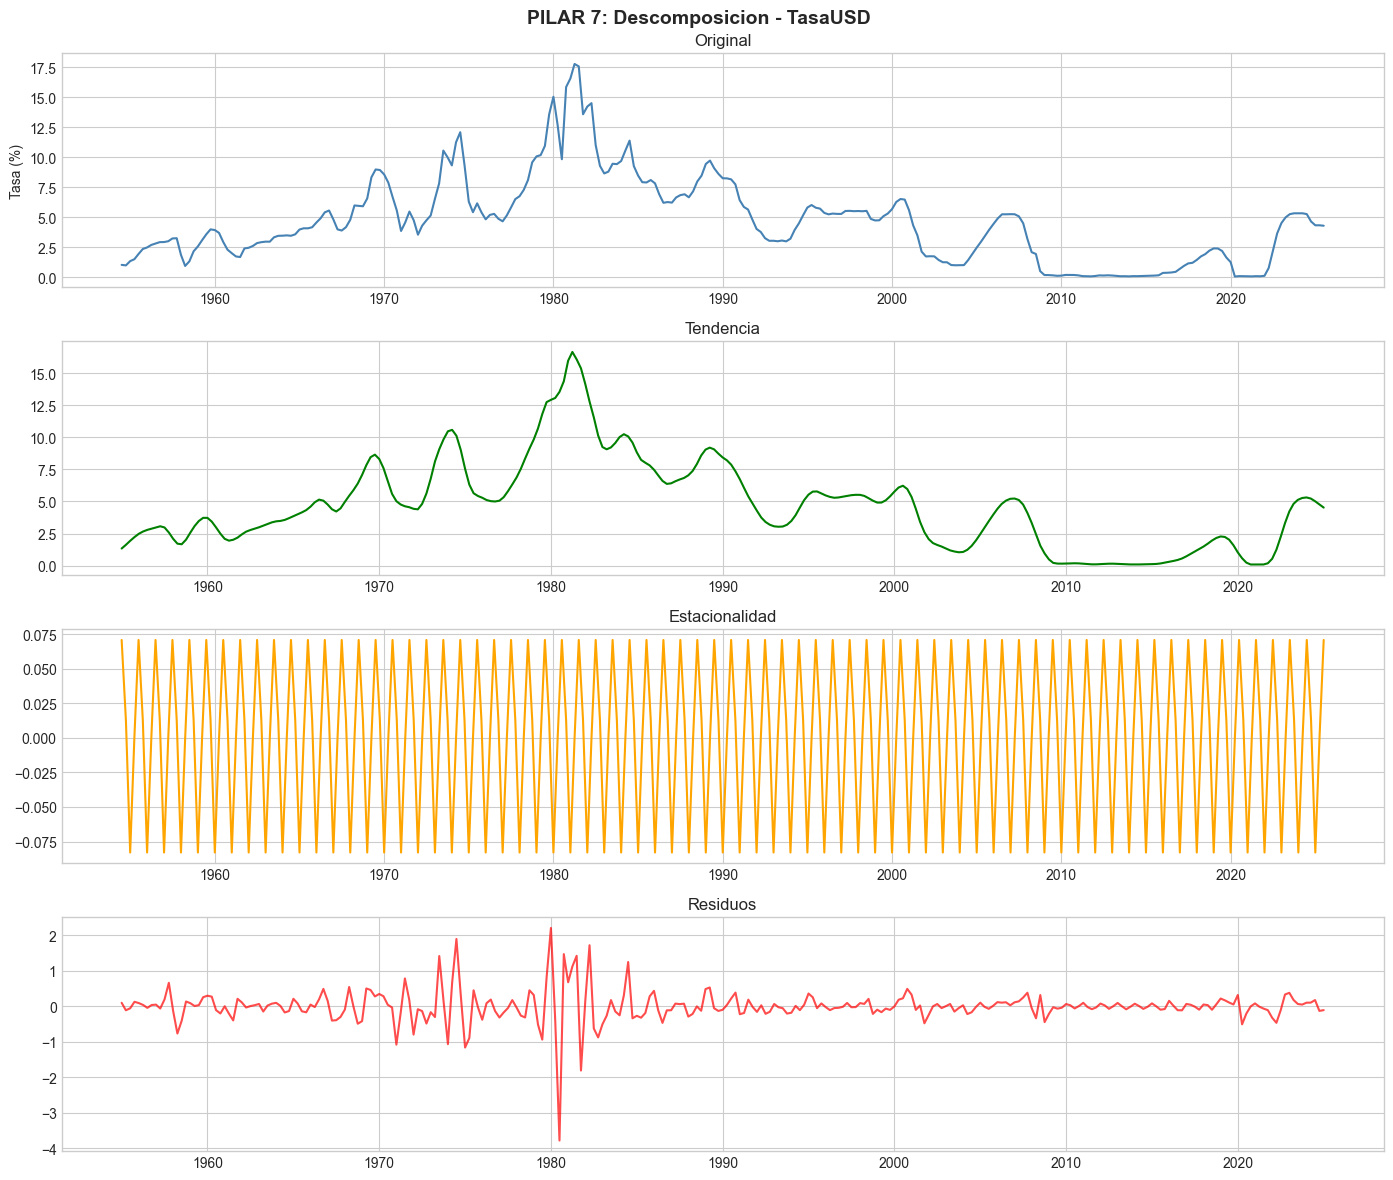

In [17]:
if len(ts_data.dropna()) >= 8:
    decomp = seasonal_decompose(ts_data.dropna(), model='additive', period=4)
    
    fig, axes = plt.subplots(4, 1, figsize=(14, 12))
    fig.suptitle(f'PILAR 7: Descomposicion - {ts_var}', fontsize=14, fontweight='bold')
    
    axes[0].plot(ts_data, color='steelblue')
    axes[0].set_title('Original')
    axes[0].set_ylabel('Tasa (%)')
    
    axes[1].plot(decomp.trend, color='green')
    axes[1].set_title('Tendencia')
    
    axes[2].plot(decomp.seasonal, color='orange')
    axes[2].set_title('Estacionalidad')
    
    axes[3].plot(decomp.resid, color='red', alpha=0.7)
    axes[3].set_title('Residuos')
    
    plt.tight_layout()
    plt.show()

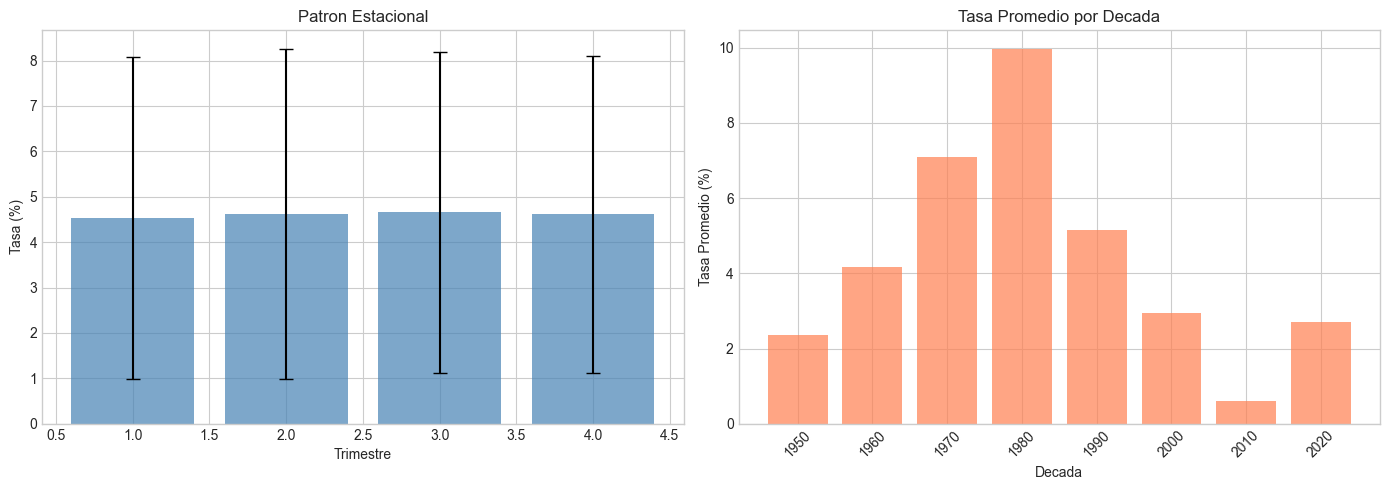

In [18]:
# Ciclos de politica monetaria
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Patron trimestral
if ts_var in df.columns:
    patron = df.groupby('TRIMESTRE')[ts_var].agg(['mean', 'std'])
    axes[0].bar(patron.index, patron['mean'], yerr=patron['std'], capsize=5, color='steelblue', alpha=0.7)
    axes[0].set_xlabel('Trimestre')
    axes[0].set_ylabel('Tasa (%)')
    axes[0].set_title('Patron Estacional')

# Promedio por decada
df['decada'] = (df['year'] // 10) * 10
prom_dec = df.groupby('decada')[ts_var].mean()
axes[1].bar(prom_dec.index.astype(str), prom_dec.values, color='coral', alpha=0.7)
axes[1].set_xlabel('Decada')
axes[1].set_ylabel('Tasa Promedio (%)')
axes[1].set_title('Tasa Promedio por Decada')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

---
## PILAR 8: ANOVA

In [19]:
print("PILAR 8: ANOVA")
print("="*60)

test_var = ts_var

# Por trimestre
grupos = [df[df['TRIMESTRE'] == t][test_var].dropna() for t in [1, 2, 3, 4]]
grupos = [g for g in grupos if len(g) >= 3]

if len(grupos) >= 2:
    f_stat, p_anova = stats.f_oneway(*grupos)
    print(f"Por Trimestre: F={f_stat:.4f}, p={p_anova:.4f}")
else:
    f_stat, p_anova = 0, 1.0

# Por decada
grupos_dec = [df[df['decada'] == d][test_var].dropna() for d in df['decada'].unique()]
grupos_dec = [g for g in grupos_dec if len(g) >= 3]

if len(grupos_dec) >= 2:
    f_stat2, p_anova2 = stats.f_oneway(*grupos_dec)
    print(f"Por Decada: F={f_stat2:.4f}, p={p_anova2:.6f}")
else:
    f_stat2, p_anova2 = 0, 1.0

PILAR 8: ANOVA
Por Trimestre: F=0.0159, p=0.9973
Por Decada: F=78.8257, p=0.000000


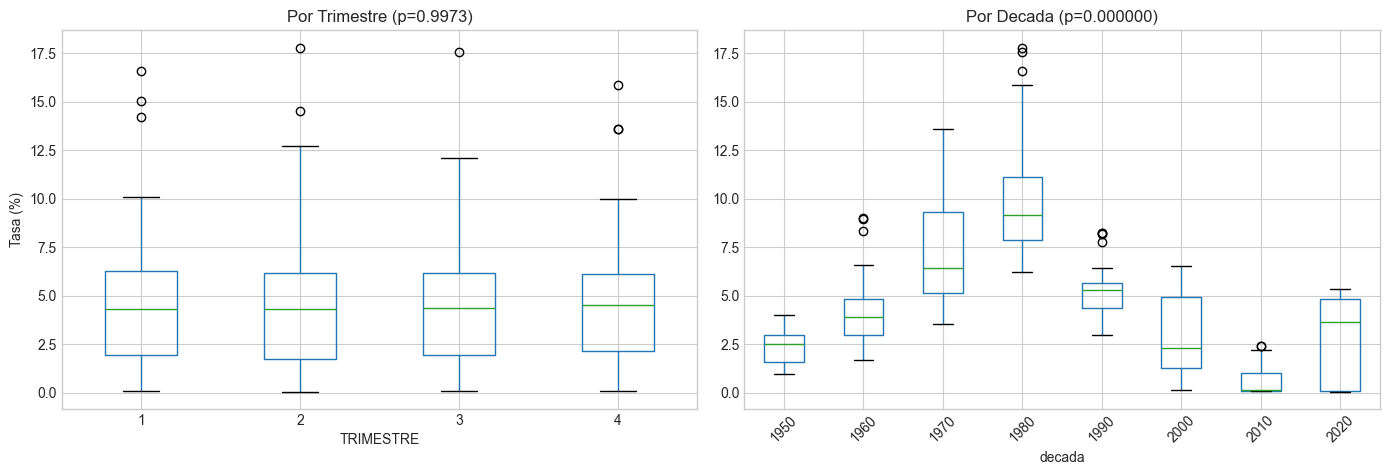

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('PILAR 8: ANOVA', fontsize=14, fontweight='bold')

df.boxplot(column=test_var, by='TRIMESTRE', ax=axes[0])
axes[0].set_title(f'Por Trimestre (p={p_anova:.4f})')
axes[0].set_ylabel('Tasa (%)')
plt.suptitle('')

df.boxplot(column=test_var, by='decada', ax=axes[1])
axes[1].set_title(f'Por Decada (p={p_anova2:.6f})')
axes[1].tick_params(axis='x', rotation=45)
plt.suptitle('')

plt.tight_layout()
plt.show()

---
## RESUMEN EJECUTIVO

In [21]:
print("="*70)
print("RESUMEN: 8 PILARES - TASAS DE INTERES")
print("="*70)

print(f"\n1. DISTRIBUCIONES: Ver resultados arriba")

print(f"\n2. CENTRO DE GRAVEDAD:")
for var in cols_numericas:
    data = df[var].dropna()
    print(f"   - {var}: Media={data.mean():.2f}%, Actual={data.iloc[-1]:.2f}%")

print(f"\n3. FIABILIDAD: Ver tabla de CV arriba")

print(f"\n4. MARGEN DE ERROR: Ver IC arriba")

print(f"\n5. CHI-CUADRADA:")
print(f"   - Tasa vs Trimestre: p={p_value:.4f}")
print(f"   - Direccion vs Decada: p={p_value_2:.6f}")

print(f"\n6. ML: {mejor_modelo}")
if len(df_resultados) > 0:
    print(f"   R2={df_resultados.iloc[0]['R2']:.4f}")

print(f"\n7. SERIES: {'ESTACIONARIA' if adf_result[1] < 0.05 else 'NO ESTACIONARIA'}")

print(f"\n8. ANOVA:")
print(f"   - Trimestre: p={p_anova:.4f}")
print(f"   - Decada: p={p_anova2:.6f}")

print("\n" + "="*70)

RESUMEN: 8 PILARES - TASAS DE INTERES

1. DISTRIBUCIONES: Ver resultados arriba

2. CENTRO DE GRAVEDAD:
   - TasaMXN: Media=6.20%, Actual=7.50%
   - TasaUSD: Media=4.61%, Actual=4.29%
   - Spread: Media=4.84%, Actual=3.55%

3. FIABILIDAD: Ver tabla de CV arriba

4. MARGEN DE ERROR: Ver IC arriba

5. CHI-CUADRADA:
   - Tasa vs Trimestre: p=0.9821
   - Direccion vs Decada: p=0.000133

6. ML: Random Forest
   R2=0.8916

7. SERIES: NO ESTACIONARIA

8. ANOVA:
   - Trimestre: p=0.9973
   - Decada: p=0.000000

